# Uppsala Districts 
The goal of this analysis is to study the different district of uppsala to identidy the most relevant one for finding a place to live, according to my needs, but input parameters can be changed to fit the needs of the user.

# import libraries and data 

In [2]:
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import geopy
import mapclassify
from geopy.geocoders import Nominatim
import geocoder
from shapely.geometry import Point, Polygon
import pyrosm
from db import Database
from shapely.wkt import loads
from shapely import wkb
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx


db = Database()

data_folder = '../data/'



connecting to default database ...
connected to db 


read files about the administrative border of the county of Uppsala, there are different leveles, level 1 discriminates between the city of Uppsala and the rest of the county, level 3 discriminates between the different districts. 

In [3]:
# Read in the data
df1 = gpd.read_file(data_folder + 'NYKO_2017_-_nivå_1.geojson')
df3 = gpd.read_file(data_folder + 'NYKO_2017_-_nivå_3.geojson')

## spatial projection
Since the data is in the WGS84, a coordinate system using lat and long we need to project it to the right coordinate system for Sweden. One option is to use the UTM projection that devide the worls in slices of 6 degrees and uses a cilindrical projection. The right variant is the UTM zone 33N that covers the area of Uppsala. But working for small maps at that latitute it is more appropriate to use the SWEREF99 TM projection (epsg:3006). 


In [4]:
proj = 'EPSG:3006'

df1 = df1.to_crs(proj) 
df3 = df3.to_crs(proj)


## spatial operation
I'm not interested in all the data but only the district of the city of Uppsala, i can use spatial operations to get the districts that are inside the city of Uppsala according to the level1 data.

For each district i compute the centroid and i check if it is inside the city of Uppsala.

In [5]:
df3['centroid'] = df3['geometry'].centroid
df3['is_city'] = df3['centroid'].within(df1.loc[0].geometry)
df = df3[df3.is_city]
df = df.rename(columns={'N3Namn17': 'name', 'N3Kod17': 'district_id'}) 


<AxesSubplot:>

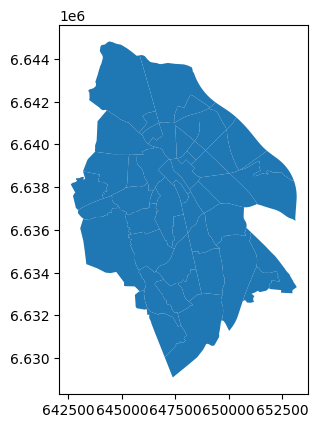

In [6]:
df.plot()

# geocoding 
This analysis is aimed to find the best house in the city of Uppsala according to my needs. One of that is the distance to the university, and starting from the name i can get the coordinates of the university and project to the right ptojection. 

In [7]:
# find university lat and long and project to the right coordinate system


uni_name = "Ångströmlaboratoriet, Uppsala"
location = geocoder.osm(uni_name)
uni_coords = location.latlng
uni = Point(uni_coords[1], uni_coords[0])
uni = gpd.GeoDataFrame({'geometry': uni}, index=[0], crs="EPSG:4326").to_crs(proj)#.geometry[0]



<AxesSubplot:>

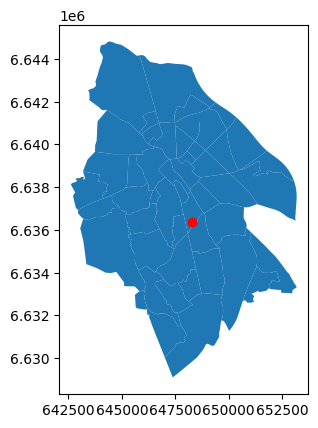

In [8]:
ax = df.plot()
uni.plot(ax=ax, color='red')

# open street map 
Data about bus stops and lines in important to understand the reachability of the university and the city center. The data has been saved on a postgresql using osm2psql. In this way i can easily query the OpenStreetMap data using SQL.

In [9]:

buildings_query = "SELECT name, ST_AsBinary(way) FROM planet_osm_polygon WHERE building = 'yes'"
stop_query = "SELECT name, ST_AsBinary(way) FROM planet_osm_point WHERE highway='bus_stop'"
busroutes_query = "select ref,  ST_AsBinary(way) from planet_osm_line where route = 'bus'"
market_query = "SELECT name, ST_AsBinary(way) FROM planet_osm_point WHERE shop='supermarket'"
fastfood_query = "SELECT name, ST_AsBinary(way) FROM planet_osm_point WHERE amenity='fast_food'"


def query_osm(query, proj):
    results = db.query(query)
    data = {}
    for i,  result in enumerate(results):
        data[i] = { 'geometry' : wkb.loads(result[1].hex(), hex=True).wkt, 'name': result[0]  }    # convert to wkt

    data = gpd.GeoDataFrame.from_dict(data, orient='index', columns=['name','geometry'])
    data['geometry'] = data['geometry'].apply(loads)            # convert to shapely geometry
    data.crs = "EPSG:900913"                                    # the projection of the data in the database
    data = data.to_crs(proj)
    return data

In [10]:
# load osm file from db and project to the right coordinate system

bus_stops = query_osm(stop_query, proj)
supermarkets = query_osm(market_query, proj)
bus_routes = query_osm(busroutes_query, proj)
fast_foods = query_osm(fastfood_query, proj)



bus_routes.set_index('name', inplace=True)


Executing query: SELECT name, ST_AsBinary(way) FROM planet_osm_point WHERE highway='bus_stop'
Fetching results...
Got 946 results
Executing query: SELECT name, ST_AsBinary(way) FROM planet_osm_point WHERE shop='supermarket'
Fetching results...
Got 33 results
Executing query: select ref,  ST_AsBinary(way) from planet_osm_line where route = 'bus'
Fetching results...
Got 740 results
Executing query: SELECT name, ST_AsBinary(way) FROM planet_osm_point WHERE amenity='fast_food'
Fetching results...
Got 54 results


The bus stops that pass near the university are only 4 and 12 so i will consider only the stops that serves these 2 lines.

In [11]:

# for each bus stop get distance from 4 and 12 routes
bus_stops['distance4'] = bus_stops.apply(lambda row: row.geometry.distance( bus_routes.loc['4'].iloc[1]['geometry']), axis=1)
bus_stops['distance12'] = bus_stops.apply(lambda row: row.geometry.distance( bus_routes.loc['12'].iloc[0]['geometry']), axis=1)

# filter stops and routes to the ones that pass from the uni
bus_stops_uni = bus_stops.loc[(bus_stops['distance4'] < 50) | (bus_stops['distance12'] < 50)]
bus_routes_uni = bus_routes.loc[['4', '12']]


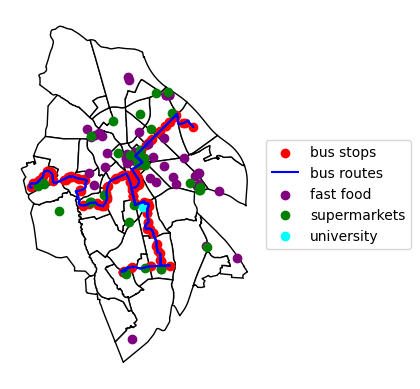

In [12]:
ax = df.plot(color='white', edgecolor='black')
bus_stops_uni.plot(ax=ax, color='red')
bus_routes_uni.plot(ax=ax, color='blue')
fast_foods.plot(ax=ax, color='purple')
supermarkets.plot(ax=ax, color='green')
uni.plot(ax=ax, color='cyan')

# add legend outside the plot 
ax.legend(['bus stops', 'bus routes', 'fast food', 'supermarkets', 'university'], loc='center left', bbox_to_anchor=(1, 0.5))

# remove axis
ax.axis('off')
plt.show()

From the first geodf we devided the city in districts, now i want to add data for each district according to the bus stops. The first step is to 

In [13]:
def get_district(row):
    district =  df[df.contains(row.geometry)]
    if len(district) > 0:
        district = district.iloc[0]['name']
    else:
        district = None
    return district



supermarkets['district'] = supermarkets.apply(get_district, axis=1)
bus_stops['district'] = bus_stops.apply(get_district, axis=1)
fast_foods['district'] = fast_foods.apply(get_district, axis=1)



In [14]:
bus_stops = bus_stops[-bus_stops['district'].isna()]
stop_frequence = bus_stops.value_counts('district').to_frame().reset_index()
stop_frequence.rename(columns={0: 'bus_stop_count'}, inplace=True)

supermarkets = supermarkets[-supermarkets['district'].isna()]
supermarket_frequence = supermarkets.value_counts('district').to_frame().reset_index()
supermarket_frequence.rename(columns={0: 'supermarket_count'}, inplace=True)


fast_foods = fast_foods[-fast_foods['district'].isna()]
fast_food_frequence = fast_foods.value_counts('district').to_frame().reset_index()
fast_food_frequence.rename(columns={0: 'fast_food_count'}, inplace=True)


In [15]:
df2 = df.merge(stop_frequence, left_on='name', right_on='district')
df2 = df2.merge(supermarket_frequence, left_on='name', right_on='district', how='left')
df2 = df2.merge(fast_food_frequence, left_on='name', right_on='district', how='left')

df2['supermarket_count'] = df2['supermarket_count'].fillna(0).astype(int)
df2['fast_food_count'] = df2['fast_food_count'].fillna(0).astype(int)

# remove column with district name
df2.drop(columns=['district_x', 'district_y', 'district'], inplace=True)



# choropleth map
looking at the choroplet map we can see a certain degree of correlation between the number of bus stops, the number of supermarket and the number of fast_foods. The centrum district is the one with the highest concentration of all the services.

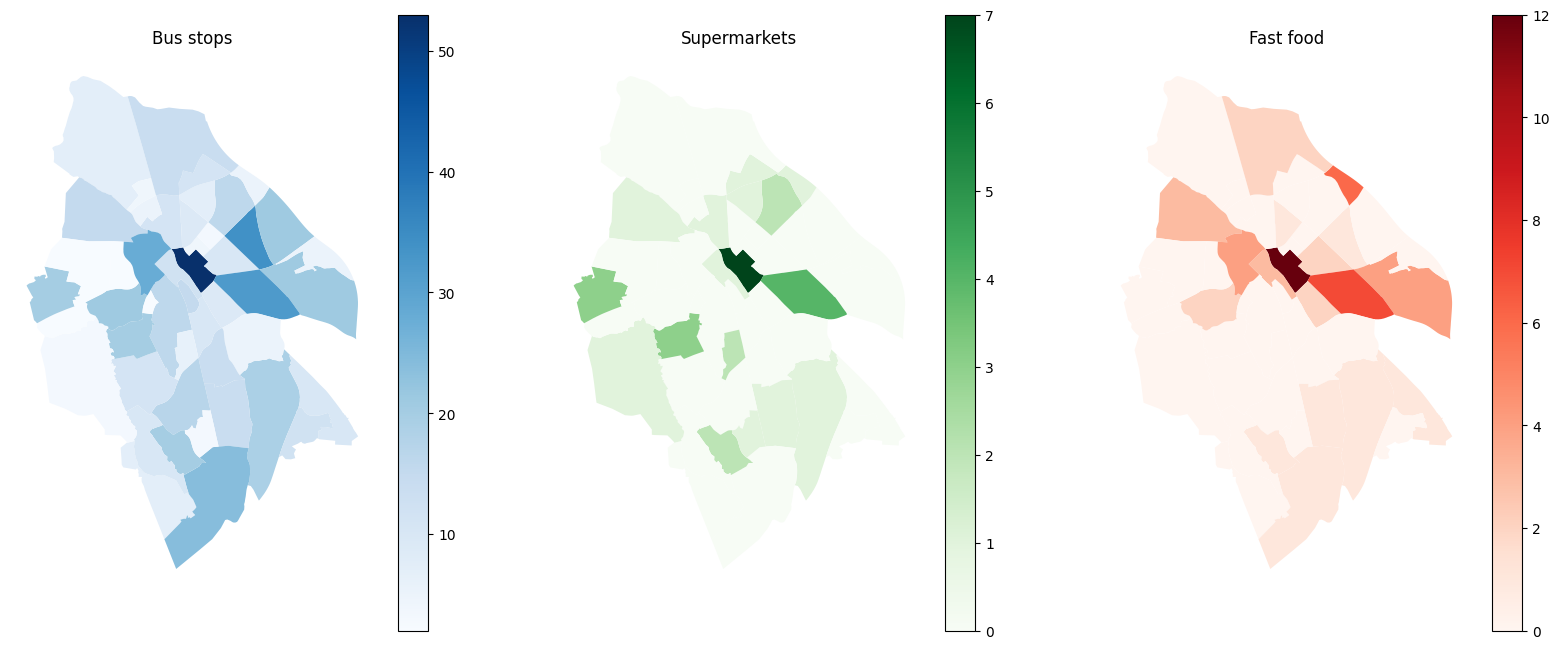

In [16]:

fig, ax = plt.subplots(1, 3, figsize=(20, 8))
df2.plot(column='bus_stop_count', cmap='Blues', legend=True, ax=ax[0])
df2.plot(column='supermarket_count', cmap='Greens', legend=True, ax=ax[1])
df2.plot(column='fast_food_count', cmap='Reds', legend=True, ax=ax[2])

# remove axis
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

# add title
ax[0].set_title('Bus stops')
ax[1].set_title('Supermarkets')
ax[2].set_title('Fast food')

plt.show()

from the choroplet maps we have seen the best districts according to the services, but let's see now the best district according to the reachability. This plot makes sense in fact all the district with the bus stops are represented in red, so with distance 0 

<AxesSubplot:>

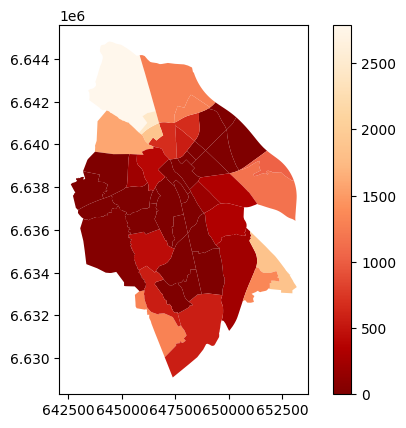

In [17]:
df2['4distance'] = df2.apply(lambda row: row.geometry.distance( bus_routes.loc['4'].iloc[1]['geometry']), axis=1)
df2['12distance'] = df2.apply(lambda row: row.geometry.distance( bus_routes.loc['12'].iloc[0]['geometry']), axis=1)
df2['bus_distance'] = df2[['4distance', '12distance']].min(axis=1)

df2.plot(column='bus_distance', cmap='OrRd_r', k=2, legend=True)


# netowrk analysis 
I'm also interestes in the walk and bike distance from the university to each district.

In [18]:

 
G = ox.graph_from_point(center_point=(59.8586, 17.6389), dist=8000, network_type='walk')# run 1 min e 30
G = ox.project_graph(G)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)


# this function compute the distance between two points using the osmnx library
def get_distance(start, end, G):

    #find closest node in the network to the start and end points
    start_node = ox.distance.nearest_nodes(G, Y=start.y, X=start.x)
    end_node   = ox.distance.nearest_nodes(G, Y=end.y, X=end.x)

    #find the shortest path between the nodes according to the travel time 
    route = nx.shortest_path(G, start_node, end_node, weight='travel_time')
    
    #get the length of the route
    edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, 'length')
    distance = sum(edge_lengths)

    return distance

for each district i compute the distance to the  uni.

In [19]:
# for each district find the distance of the closest bus (45 sec)

uni_coord = uni.loc[0, 'geometry']
df2['uni_distance'] = df2.apply(lambda row: get_distance(uni_coord, row['centroid'], G), axis=1)


<AxesSubplot:>

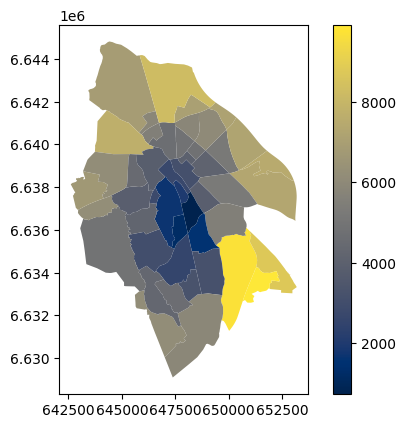

In [20]:
df2.plot(column='uni_distance', cmap='cividis', k=2, legend=True)

# raster data 

# spatial regression
https://www.lantmateriet.se/sv/geodata/vara-produkter/produktlista/markhojdmodell-nedladdning-grid-50/

Durbin model, local and global spilpver

In [21]:
import pandas as pd 
df = pd.read_table(data_folder + 'elevation.xyz', skiprows=2, delim_whitespace=True, names=['x', 'y', 'z'])


In [22]:
# all commas to dots 
df['x'] = df['x'].str.replace(',', '.').astype(float)
df['y'] = df['y'].str.replace(',', '.').astype(float)
df['z'] = df['z'].str.replace(',', '.').astype(float)



In [23]:
# geodf from df
altitude = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))

In [24]:


xmin, ymin, xmax, ymax = df2.total_bounds
alt = altitude.cx[xmin:xmax, ymin:ymax]




(642082.6287077797, 653712.4426025586, 6628306.458193868, 6645597.00976359)

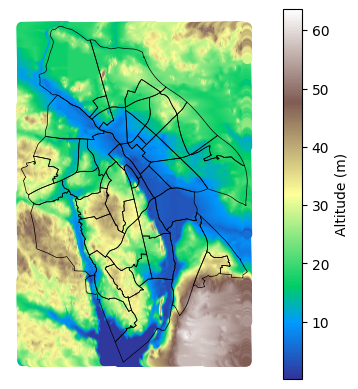

In [27]:

ax = alt.plot(column='z', cmap='terrain')
df2.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
# show legend 
plt.colorbar(ax.collections[0], label='Altitude (m)')
ax.axis('off')
plt.show()

# Spatial regession


# conclusion

This map is interesting, we can notice the linear pattern of the fast food count and some outliers. With a more careful eyes we can see the main street(186) that, when it splits for the center to the city we can see the fast food following this patterns. this explains also the outliers on the north-east of the city. 

In [28]:
df2.explore(column='fast_food_count', cmap='Reds', legend=True)

In [ ]:
df2.explore(column='supermarket_count', cmap='Blues', k=2, legend=True)

let's find the districts that have
- at least1 supermarket and 1 fast food
- on the right bus path or less then 10 min bike distance
- 

In [ ]:
# let's find the districts that have
# - at least1 supermarket and 1 fast food
# - on the right bus path or less then 10 min bike distance

df2.query("supermarket_count > 0 & fast_food_count > 0 &( bus_distance == 0 | uni_distance < 2000)").explore()